In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns

In [3]:
file = 'data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
data.describe()

,z,hz,err
count,31.000000,31.000000,31.000000
mean,0.661219,105.922581,21.303226
std,0.520398,38.413424,14.587768
min,0.070000,68.600000,4.000000
25%,0.275000,78.950000,12.000000
50%,0.470000,90.000000,17.000000
75%,0.890000,121.000000,27.900000
max,1.965000,202.000000,62.000000


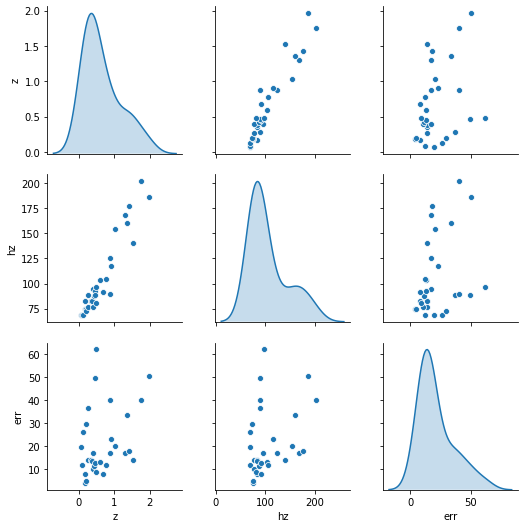

In [4]:
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistHD.png")

In [5]:
# a = np.array([16, 21,  9, 15, 10,  8, 29, 17, 24, 27, 12,  0, 23, 20, 19, 3, 14,  7, 25,  4,  2,  1, 13, 18,
#   6, 26, 11, 22,  5, 30, 28])
a = np.array([25, 3, 2, 27, 14, 30, 21, 9, 8, 18, 20, 6, 22, 19, 5, 17, 4, 13, 0, 24, 29, 7, 15, 1, 12, 23, 16, 28, 10, 26, 11])
randomize = np.random.permutation(len(data.values))
data = data.values[a]

In [6]:
# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)


Read the data for cosmic chronometers

In [7]:

# odds = [x for x in range(len(data)) if x%2 ==0]
# even = [x for x in range(len(data)) if x%2 ==1]
# new_order = np.array(even+odds)
# new_order = np.array([x for x in range(len(data)-1, 0, -1)])
# data = data.values[new_order]
# data = data.values


In [8]:
z = data[:,0]
y = data[:,1:]
print(randomize)

[18  2 27 26 20 10 22  3 29 15 21  6  7  8 19  9 16 28 24 13  4 11  5 25
 12  1 17 30  0 14 23]


In [9]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery.fit(y)
# y = scalery.transform(y)

In [10]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [11]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
# initializer = Constant(value=0.01)
initializer = RandomNormal()


In [12]:
# def autoencoder(input_z):
#     #encoder
#     #input = 28 x 28 x 1 (wide and thin)
#     efirst = Dense(200, kernel_initializer=initializer, activation='relu', input_shape=(1,))(input_z)
#     ehidden = Dense(100, kernel_initializer=initializer, activation='relu')(efirst)
# #     ehidden2 = Dense(160, activation='relu')(ehidden)
# #     ehidden3 = Dense(150, activation='relu')(ehidden2)
# #     ehidden4 = Dense(100, activation='relu')(ehidden3)
#     elast = Dense(50, kernel_initializer=initializer, activation='relu')(ehidden)
#     coded = Dense(10, kernel_initializer=initializer, activation='relu')(elast)
#     #decoder 
#     dfirst = Dense(50, kernel_initializer=initializer, activation='relu')(coded)
#     dhidden = Dense(100, kernel_initializer=initializer, activation='relu')(dfirst)
# #     dhidden2 = Dense(180, kernel_initializer=initializer, activation='relu')(dhidden)
# #     dhidden3 = Dense(200, activation='relu')(dhidden2)
# #     dhidden4 = Dense(50, activation='relu')(dhidden3)
#     dlast = Dense(200, kernel_initializer=initializer, activation='relu')(dhidden)
#     decoded = Dense(2, kernel_initializer=initializer, activation='relu')(dlast)
    
#     return decoded

In [13]:
def autoencoder(input_z):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    efirst = Dense(200, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(100, activation='relu')(efirst)
#     ehidden2 = Dense(160, activation='relu')(ehidden)
#     ehidden3 = Dense(150, activation='relu')(ehidden2)
#     ehidden4 = Dense(100, activation='relu')(ehidden3)
    elast = Dense(50, activation='relu')(ehidden)
    coded = Dense(10, activation='relu')(elast)
    #decoder 
    dfirst = Dense(50, activation='relu')(coded)
    dhidden = Dense(100, activation='relu')(dfirst)
#     dhidden2 = Dense(180, kernel_initializer=initializer, activation='relu')(dhidden)
#     dhidden3 = Dense(200, activation='relu')(dhidden2)
#     dhidden4 = Dense(50, activation='relu')(dhidden3)
    dlast = Dense(200, activation='relu')(dhidden)
    decoded = Dense(2, activation='relu')(dlast)
    
    return decoded

In [14]:
batch_size = 4
epochs = 500
input_z = Input(shape = (1,))

In [15]:
autoencoder = Model(input_z, autoencoder(input_z))
autoencoder.compile(loss='mean_squared_error', optimizer = "adam")
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 200)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_5 (Dense)              (None, 100)              

In [16]:
autoencoder_train = autoencoder.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test),
                                    callbacks=callbacks)

Epoch 1/500
6/6 [==============================] - 0s 21ms/step - loss: 6713.1675 - val_loss: 6385.5659
Epoch 2/500
6/6 [==============================] - 0s 3ms/step - loss: 6667.8867 - val_loss: 6315.6401
Epoch 3/500
6/6 [==============================] - 0s 5ms/step - loss: 6558.1562 - val_loss: 6143.2617
Epoch 4/500
6/6 [==============================] - 0s 4ms/step - loss: 6284.1577 - val_loss: 5734.0474
Epoch 5/500
6/6 [==============================] - 0s 4ms/step - loss: 5635.3940 - val_loss: 4744.5264
Epoch 6/500
6/6 [==============================] - 0s 4ms/step - loss: 4242.4595 - val_loss: 2741.9221
Epoch 7/500
6/6 [==============================] - 0s 5ms/step - loss: 2488.3342 - val_loss: 693.5024
Epoch 8/500
6/6 [==============================] - 0s 4ms/step - loss: 1094.3569 - val_loss: 341.2518
Epoch 9/500
6/6 [==============================] - 0s 4ms/step - loss: 725.9868 - val_loss: 325.9754
Epoch 10/500
6/6 [==============================] - 0s 4ms/step - loss: 549.

6/6 [==============================] - 0s 3ms/step - loss: 175.5065 - val_loss: 162.6117
Epoch 82/500
6/6 [==============================] - 0s 4ms/step - loss: 185.1305 - val_loss: 167.2757
Epoch 83/500
6/6 [==============================] - 0s 4ms/step - loss: 196.7240 - val_loss: 104.2024
Epoch 84/500
6/6 [==============================] - 0s 4ms/step - loss: 167.0693 - val_loss: 216.8133
Epoch 85/500
6/6 [==============================] - 0s 3ms/step - loss: 191.5997 - val_loss: 184.4779
Epoch 86/500
6/6 [==============================] - 0s 4ms/step - loss: 174.9973 - val_loss: 106.9056
Epoch 87/500
6/6 [==============================] - 0s 4ms/step - loss: 172.0707 - val_loss: 157.6247
Epoch 88/500
6/6 [==============================] - 0s 4ms/step - loss: 173.0663 - val_loss: 179.0581
Epoch 89/500
6/6 [==============================] - 0s 3ms/step - loss: 174.4268 - val_loss: 121.1711
Epoch 90/500
6/6 [==============================] - 0s 3ms/step - loss: 167.5303 - val_loss: 17

Epoch 161/500
6/6 [==============================] - 0s 3ms/step - loss: 161.4750 - val_loss: 200.7869
Epoch 162/500
6/6 [==============================] - 0s 3ms/step - loss: 176.5969 - val_loss: 147.6472
Epoch 163/500
6/6 [==============================] - 0s 3ms/step - loss: 163.4416 - val_loss: 177.0903


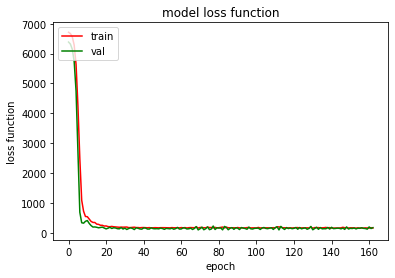

In [37]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
plt.title('model loss function')
plt.ylabel('loss function')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_ae.png")
# plt.savefig("LOSS_Overfitting_synthetic_HD.png")

In [18]:
#uncer net
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
unet

10.059777312041808

In [19]:
pred = autoencoder.predict(z_test)
pred

array([[ 81.28656 ,  17.478561],
       [112.20318 ,  23.965979],
       [ 86.75886 ,  18.626154],
       [160.82869 ,  34.226597],
       [ 79.91363 ,  17.19063 ],
       [148.3657  ,  31.597641],
       [ 81.25888 ,  17.472755]], dtype=float32)

In [20]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [21]:
ranz = np.random.uniform(0, 2, size=10000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = autoencoder.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


(0.0, 2.0)

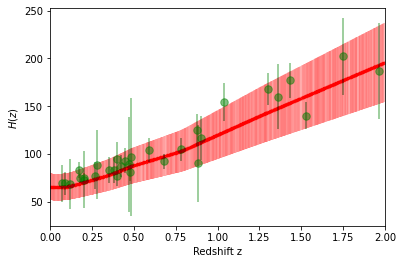

In [22]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
# plt.savefig("Overfitting_synthetic_HD.png")

In [23]:
# Cosmological constants
Om = 0.27
# variance network


In [24]:
def Hlcdm(z, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

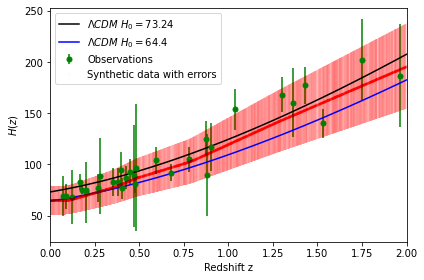

In [33]:
z = np.linspace(0, 2, 10000)
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)

plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
plt.plot(z, Hlcdm(z, H0=64.4), label='$\Lambda CDM$ $H_0 = 64.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend()

plt.savefig("SyntheticHDrelu.png",dpi=800)

In [26]:
pred_random.shape, r.shape

((10000, 2), (10000, 1))

In [38]:
randomselection = np.random.randint(0,1000,50)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [39]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)


np.savetxt("autoEncoderHz50.dat",mookHz, delimiter=" ")

In [29]:
predy_reduced[:,1]

array([19.99122 , 14.106892, 37.82671 , 22.709406, 38.309696, 38.17893 ,
       33.6298  , 17.615503, 34.0592  , 38.309696, 15.2264  , 22.14427 ,
       29.247583, 15.416098, 14.752119, 14.105076, 24.10592 , 40.638233,
       18.062513, 28.113142, 19.947609, 16.04381 , 35.42393 , 32.327503,
       29.33233 , 20.737797, 38.618404, 24.904074, 27.095617, 18.030222,
       19.272306, 26.868454, 14.140381, 16.53818 , 21.115583, 16.11207 ,
       38.73628 , 15.746579, 24.17336 , 14.158657, 21.965115, 16.364649,
       19.549711, 37.578712, 16.051947, 28.78816 , 36.196938, 26.944525,
       39.265263, 31.366308, 36.26076 , 19.974977, 40.69698 , 35.732025,
       27.749685, 14.102979, 14.151468, 19.048883, 14.31122 , 21.696531,
       20.294842, 30.892836, 39.698376, 15.654906, 18.38126 , 39.29293 ,
       27.979254, 38.139744, 28.06264 , 31.35085 , 20.135695, 17.668753,
       25.139181, 17.15421 , 29.639917, 20.87406 , 27.321867, 26.52753 ,
       21.319921, 19.145426, 27.398787, 33.082638, 

In [30]:
error  = predy_reduced[:,1]**2
error

array([ 399.6489 ,  199.0044 , 1430.86   ,  515.7171 , 1467.6328 ,
       1457.6306 , 1130.9634 ,  310.30597, 1160.0292 , 1467.6328 ,
        231.84326,  490.36868,  855.42114,  237.65607,  217.62502,
        198.95317,  581.0954 , 1651.466  ,  326.2544 ,  790.34875,
        397.9071 ,  257.40384, 1254.8549 , 1045.0675 ,  860.3856 ,
        430.0562 , 1491.3811 ,  620.2129 ,  734.1725 ,  325.0889 ,
        371.42178,  721.9138 ,  199.95038,  273.51138,  445.86786,
        259.59882, 1500.4993 ,  247.95476,  584.3514 ,  200.46758,
        482.46625,  267.80173,  382.19122, 1412.1597 ,  257.66498,
        828.7582 , 1310.2183 ,  726.0074 , 1541.7609 ,  983.8453 ,
       1314.8428 ,  398.99973, 1656.2441 , 1276.7776 ,  770.04504,
        198.89401,  200.26405,  362.85995,  204.81102,  470.73947,
        411.8806 ,  954.3673 , 1575.961  ,  245.0761 ,  337.87073,
       1543.9344 ,  782.8386 , 1454.64   ,  787.5117 ,  982.87573,
        405.4462 ,  312.1848 ,  631.97845,  294.26688,  878.52

In [40]:
diagcov = np.diag(error) #inverso
np.savetxt("autoEncoderHz_cov50.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(100, 100)

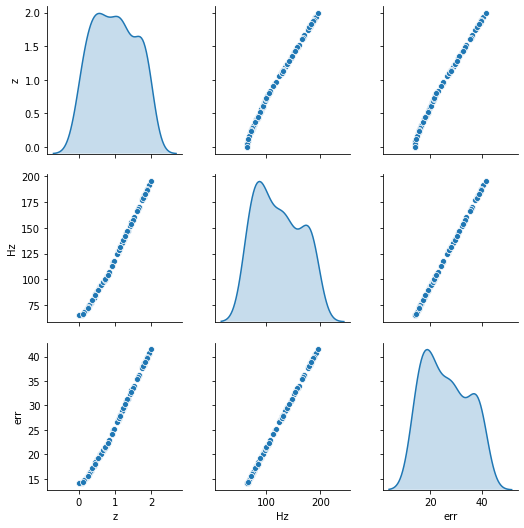

In [36]:
dfMook = pd.DataFrame(mookHz, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("100hdmook.png")